In [20]:
import os
import requests
from zipfile import ZipFile
from urllib.request import urlretrieve
import pandas as pd
import numpy as np
#import altair as alt
#from vega_datasets import data
%matplotlib inline
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import statsmodels.api as sm
from sklearn.feature_selection import RFECV
from sklearn.ensemble import *
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import *
from sklearn.metrics import *
import pycaret
from pycaret.classification import *
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
import re
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV


In [15]:
df = pd.read_csv(r'C:\Users\tegan\Downloads\clean_df.csv')
df.rename(columns={'Ethnicity_Multiracial, non-Hispanic': 'Ethnicity_Multiracial non-Hispanic'}, inplace=True)
df.head()

,Gender,Age Group,Num of Bad Mental Health Days,Could Afford Doctor,Years Since Last Checkup,Exercise in Past 30 Days,Hours of Sleeping,Heart Attack,Heart Disease,Stroke,...,Ethnicity_American Indian and Alaskan Native,Ethnicity_Asian and Pacific Islander,Ethnicity_Black,Ethnicity_Hispanic,Ethnicity_Multiracial non-Hispanic,Ethnicity_White,Education_attended_college,Education_did_not_graduate_high_school,Education_graduated_college,Education_graduated_high_school
0,0,5.0,0.0,0.0,1.0,1.0,9.0,0.0,0.0,0.0,...,False,False,False,False,False,True,True,False,False,False
1,0,13.0,0.0,0.0,1.0,1.0,7.0,0.0,0.0,0.0,...,False,False,True,False,False,False,False,False,True,False
2,0,13.0,0.0,0.0,1.0,0.0,8.0,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,False,True
3,1,8.0,0.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,...,False,False,True,False,False,False,False,False,False,True
4,0,13.0,5.0,0.0,1.0,1.0,8.0,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,False,True


In [21]:
# Separate predictors and target
X, y = df.drop('Cancer', axis=1), df.Cancer

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale data
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

### Feature Importance from RandomForestClassifier

In [22]:
forest = RandomForestClassifier(n_estimators=100,
                                max_depth=10,
                                random_state=42)

forest.fit(X_train_res, y_train_res)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

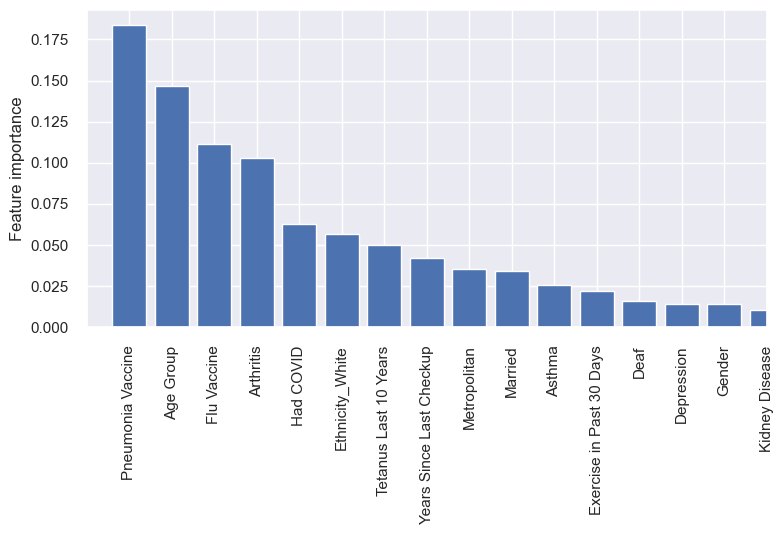

In [23]:
plt.ylabel('Feature importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

feat_labels = X.columns
plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)

plt.xlim([-1, 15])

plt.tight_layout()
plt.show()

### Compare models using imbalanced data

In [7]:
clf = setup(df, target='Cancer', session_id=123)

best_model = compare_models()

,Description,Value
0,Session id,123
1,Target,Cancer
2,Target type,Binary
3,Original data shape,"(200148, 42)"
4,Transformed data shape,"(200148, 42)"
5,Transformed train set shape,"(140103, 42)"
6,Transformed test set shape,"(60045, 42)"
7,Numeric features,31
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8865,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0790
gbc,Gradient Boosting Classifier,0.8865,0.0000,0.0026,0.4739,0.0053,0.0040,0.0285,2.3660
lightgbm,Light Gradient Boosting Machine,0.8865,0.0000,0.0042,0.5113,0.0082,0.0064,0.0377,0.3640
dummy,Dummy Classifier,0.8865,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0720
lr,Logistic Regression,0.8863,0.0000,0.0049,0.4526,0.0097,0.0072,0.0371,1.5200
ada,Ada Boost Classifier,0.8862,0.0000,0.0052,0.3851,0.0103,0.0073,0.0334,0.6170
rf,Random Forest Classifier,0.8856,0.0000,0.0065,0.3196,0.0127,0.0081,0.0307,1.9140
svm,SVM - Linear Kernel,0.8855,0.0000,0.0067,0.2096,0.0115,0.0074,0.0169,0.4910
lda,Linear Discriminant Analysis,0.8848,0.0000,0.0240,0.3833,0.0451,0.0321,0.0717,0.1700
et,Extra Trees Classifier,0.8815,0.0000,0.0240,0.2592,0.0438,0.0252,0.0474,2.2900


### Compare models using SMOTE data

In [10]:
clf = setup(df, target='Cancer', fix_imbalance=True, session_id=123)

best_model = compare_models()

,Description,Value
0,Session id,123
1,Target,Cancer
2,Target type,Binary
3,Original data shape,"(200148, 42)"
4,Transformed data shape,"(308445, 42)"
5,Transformed train set shape,"(248400, 42)"
6,Transformed test set shape,"(60045, 42)"
7,Numeric features,31
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.8865,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2470
lightgbm,Light Gradient Boosting Machine,0.8864,0.0000,0.0043,0.4564,0.0086,0.0064,0.0351,0.9810
rf,Random Forest Classifier,0.8843,0.0000,0.0138,0.2954,0.0264,0.0164,0.0418,3.9160
gbc,Gradient Boosting Classifier,0.8822,0.0000,0.0340,0.3235,0.0614,0.0405,0.0723,8.6340
et,Extra Trees Classifier,0.8800,0.0000,0.0328,0.2659,0.0584,0.0344,0.0573,5.3690
ada,Ada Boost Classifier,0.8454,0.0000,0.2081,0.2662,0.2319,0.1481,0.1501,1.9920
dt,Decision Tree Classifier,0.8034,0.0000,0.2305,0.1932,0.2102,0.0990,0.0995,0.5620
ridge,Ridge Classifier,0.7625,0.0000,0.5275,0.2457,0.3352,0.2134,0.2365,0.2570
lda,Linear Discriminant Analysis,0.7625,0.0000,0.5275,0.2457,0.3353,0.2134,0.2366,0.3950
lr,Logistic Regression,0.7618,0.0000,0.5259,0.2446,0.3339,0.2118,0.2348,4.5980


### Naive Bayes using SMOTE data

In [12]:
nb_model = create_model('nb')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5815,0.0000,0.7599,0.1807,0.2920,0.1329,0.2024
1,0.5817,0.0000,0.7750,0.1830,0.2961,0.1377,0.2108
2,0.5895,0.0000,0.7932,0.1888,0.3050,0.1489,0.2266
3,0.5845,0.0000,0.7962,0.1872,0.3031,0.1462,0.2245
4,0.5872,0.0000,0.7585,0.1826,0.2943,0.1363,0.2057
5,0.5809,0.0000,0.7767,0.1829,0.2961,0.1377,0.2111
6,0.5871,0.0000,0.7811,0.1860,0.3004,0.1433,0.2181
7,0.5824,0.0000,0.7491,0.1793,0.2893,0.1300,0.1970
8,0.5852,0.0000,0.7541,0.1811,0.2921,0.1335,0.2018


In [26]:
print(nb_model)

GaussianNB(priors=None, var_smoothing=1e-09)


In [19]:
y_pred = nb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.5863852110916813
Precision: 0.18454913082296098
Recall: 0.7733274647887324
F1 Score: 0.29798600805596775


### Naive Bayes grid search

In [24]:
param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

nb_model_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nb_model_grid.fit(X_train_res, y_train_res)
print(nb_model_grid.best_estimator_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
GaussianNB(priors=None, var_smoothing=1e-05)


In [25]:
y_pred = nb_model_grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.5925805645765676
Precision: 0.1868845478256241
Recall: 0.7726672535211268
F1 Score: 0.30097295443830097
